In [0]:
# !pip install -q gpt-2-simple
# !pip install opencv-python

import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gpt_2_simple as gpt2
import tensorflow as tf
from tensorflow.python.framework import ops
import os
import time
import re
import shutil
import pickle

In [0]:
gpt2.download_gpt2(model_name="124M")

In [0]:
input_image = glob.glob("/dbfs/FileStore/nft-hackathon/punks_all.png")[0]
output_images = "/dbfs/FileStore/nft-hackathon/small_punks"

image = cv2.imread(input_image, cv2.IMREAD_UNCHANGED)

idx_i = 0
for i in range(0, 2400, 24):
    idx_j = 0
    for j in range(0, 2400, 24):
        punk = image[i:i+24,j:j+24]
        cv2.imwrite(os.path.join(output_images, 'punk_' + str(idx_j + 100*idx_i) + '.png'), punk)
        idx_j += 1
    idx_i += 1

In [0]:
img = cv2.imread(input_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
all_rgb_codes = img.reshape(-1, img.shape[-1])
unique_rgbs = np.unique(all_rgb_codes, axis=0, return_counts = False)

rgb_color = [str(rgb) for rgb in unique_rgbs.tolist()]
code = [str(i).zfill(3) for i in range(0, 222)]
encode_map = dict(zip(rgb_color, code))
decode_map = dict(zip(code, rgb_color))

with open('/dbfs/FileStore/nft-hackathon/decode.pkl', 'wb') as handle:
    pickle.dump(decode_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
output = ''
input_folder  = "/dbfs/FileStore/nft-hackathon/small_punks"

for f in os.listdir(input_folder):
    ext = f.split('.')[-1]
    if ext not in ['png', 'gif', 'jpg', 'jpeg']:
        continue
        
    path = '%s/%s' % (input_folder, f)
    image = Image.open(path).convert('RGBA')
    pixels = image.load()
    width = image.size[0]
    height = image.size[1]

    lines = []
    for y in range(height):
        padLength = len(str(height))
        padded = str(y).zfill(padLength)
        split = [padded + 'd']

        for x in range(width):
            color = pixels[x, y][:3]

            rgb = str(list(color))
            value = encode_map[rgb]

            split.append(value)

        lines.append(' '.join(split))

    output += '\n'.join(lines)
    output += '\n'

with open('/dbfs/FileStore/nft-hackathon/all-images.txt', 'w') as output_file:
    output_file.write(output)

In [0]:
# @values

checkpoint_folder = 'checkpoints'
run_name = 'cryptopunks_2_run'
steps = 2000

if not os.path.exists('/dbfs/FileStore/nft-hackathon/%s' % checkpoint_folder):
    os.makedirs('/dbfs/FileStore/nft-hackathon/%s' % checkpoint_folder)

from tensorflow.python.framework import ops
ops.reset_default_graph()

session = gpt2.start_tf_sess()

In [0]:
session = gpt2.reset_session(session)
gpt2.finetune(session,
    dataset='all-images.txt',
    model_name='124M',
    steps=steps,
    restore_from='latest',
    run_name=run_name,
    print_every=20,
    sample_every=500,
    save_every=500,
    )

shutil.copytree( 'checkpoint/%s' % run_name, '/dbfs/FileStore/nft-hackathon/%s/%s' % (checkpoint_folder, run_name))

In [0]:
def createImage(text, path):
    lines = text.split('\n')

    imageWidth = 24
    imageHeight = 24

    pixels = []
    for y in range(imageHeight):
        for x in range(imageWidth):
            pixels.append((100, 132, 150, 255))

    for line in lines:
        split = line.split(' ')

        marker = split[0]
        match = re.search("^([0-9]+)([d])$", marker)

        if match:
            groups = match.groups()
            index = int(groups[0])

            for x in range(len(split) - 1):
                s = split[x + 1]
                match = re.search("^[0-9][0-9][0-9]$", s)
                if not match:
                    s = '079'

                rgb = eval(decode_map[s])

                i = (index * imageWidth) + x
                pixels[i] = (rgb[0], rgb[1], rgb[2], 255)

    image = Image.new('RGBA', (imageWidth, imageHeight))
    image.putdata(pixels)
    image.save(path)


def blankLines():
    lines = []

    for i in range(0, height):
        lines.append('')

    return lines

sess = None

In [0]:
decoder = 'decode.pkl'
with open('/dbfs/FileStore/nft-hackathon/%s' % decoder, 'rb') as handle:
    decode_map = pickle.load(handle)

In [0]:
output_folder = 'output_punks_new_model_final'
generate_count = 100
temperature = 0.98

In [0]:
if not os.path.exists('/dbfs/FileStore/nft-hackathon/%s' % output_folder):
    os.makedirs('/dbfs/FileStore/nft-hackathon/%s' % output_folder)

prefix = """
00d 000 000 000 000 000 020 079 000 000 000 000 079 000 000 020 079 020 000 079 000 000 000 000 000
01d 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000
"""

for img in range(0, generate_count):
    print("punk number: %i" % img)
    
    if not sess:
        sess = gpt2.start_tf_sess()
    else:
        sess = gpt2.reset_session(sess)
    
    gpt2.load_gpt2(sess, run_name=run_name)
    width = 24
    height = 24
    
    text = gpt2.generate(sess, run_name=run_name, prefix=prefix, temperature=temperature, return_as_list=True)[0]
    print("\nGPT-2 text output: \n")
    print(text)

    lines = text.split('\n')
    section = '\n'.join(lines[20:])
    newText = gpt2.generate(sess, run_name=run_name, prefix=section, temperature=temperature, return_as_list=True)[0]
    newLines = newText.split('\n')
    lines = lines[:20] + newLines
    splits = [line.split(' ') for line in lines]

    indices = [split[0] for split in splits]
    idx = indices.index('00d')

    for i, split in enumerate(splits):
        if len(split) < width + 1:
            while len(split) < width + 1:
                split.append('079')

            lines[i] = ' '.join(split)
        else:
            split = split[:width+1]
            lines[i] = ' '.join(split)
    
    output = '\n'.join(lines[:height])
    print("\nSaving output: \n")
    filename = '%i' % int(time.time())
    createImage(output, '/dbfs/FileStore/nft-hackathon/%s/%s.png' % (output_folder, filename))
    print('\nsaved !\n')

In [0]:
#Load Image 
generated_punks_final = glob.glob("/dbfs/FileStore/nft-hackathon/output_punks_new_model_final/*")

In [0]:
def show_image(idx,generated_punks_final):
    X = np.asarray(Image.open(generated_punks_final[idx])).copy()
    X[0:1:] = np.full((1,24,4),[ 0, 0, 0, 255])
    im = Image.fromarray(X)
    plt.axis('off')
    plt.imshow(im)

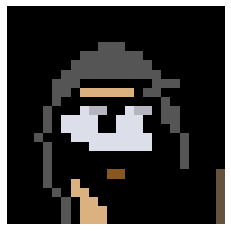

In [0]:
show_image(4,generated_punks_final)

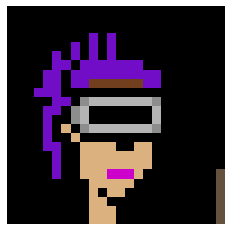

In [0]:
show_image(9,generated_punks_final)

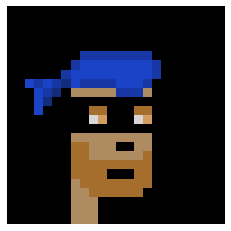

In [0]:
show_image(60,generated_punks_final)